<a href="https://colab.research.google.com/github/Sanjeivk/infralert/blob/main/Final_report_model_test_poster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
✅ Labels Loaded Correctly: {0: 'unlabeled', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'street sign', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'plate', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'ora

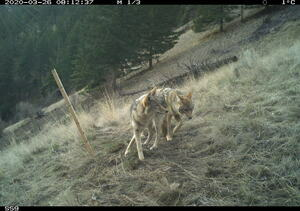

In [ ]:
# Step 1: Mount Google Drive to Access Files
from google.colab import drive
drive.mount('/content/drive')

# # Step 2: Download and Extract the Model
# !wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
# !tar -xvzf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

# Step 3: Install Dependencies
import tensorflow as tf
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

# Step 4: Load the Model
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
PATH_TO_LABELS = "ssd_mobilenet_v2_coco_2018_03_29/labels.txt"  # Use labels.txt from repo
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/labels.txt"  # Use labels.txt from repo

# Load the frozen model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

print("✅ Model loaded successfully!")

# # Step 5: Load Labels from `labels.txt`
# def load_labels_from_txt(path):
#     label_map = {}
#     with open(path, 'r') as file:
#         for i, line in enumerate(file.readlines()):
#             label_map[i + 1] = line.strip()  # Assuming labels are 1-based indexed
#     return label_map

# category_index = load_labels_from_txt(PATH_TO_LABELS)
# print("✅ Labels Loaded:", category_index)

# Step 5: Load Labels from `labels.txt` with Correct Indexing
def load_labels_from_txt(path):
    label_map = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(":")  # Split based on ":"
            if len(parts) == 2:
                index, name = parts  # Extract index and label name
                index = int(index.strip())  # Convert index to int
                name = name.strip()  # Clean up label name
                label_map[index] = name  # Store in dictionary
    return label_map

# Load corrected labels
category_index = load_labels_from_txt(PATH_TO_LABELS)
print("✅ Labels Loaded Correctly:", category_index)


# Step 6: Run Inference on an Image
def run_inference(image_path):
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"❌ Error: Image not found at {image_path}")
        return

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
            # Get model input/output tensors
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            # Run inference
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_expanded})

            # Draw bounding boxes
            for i in range(int(num[0])):
                if scores[0][i] > 0.5:  # Confidence threshold
                    box = boxes[0][i]  # Get box coordinates
                    y1, x1, y2, x2 = (box * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])).astype(int)
                    class_id = int(classes[0][i])
                    label = category_index.get(class_id , "Unknown")
                    print(f"Detected {label} with confidence {scores[0][i]}")
                    score = scores[0][i]

                    # Draw bounding box and label
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, f"{label}: {score:.2f}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Show the image with detections
            cv2_imshow(image)

# Step 7: Test the Model with an Image from Google Drive
# image_path = "/content/drive/MyDrive/archive-2/validation/human/baddie.jpg"  # Change this to your image path
# image_path = '/content/drive/MyDrive/archive-2/test/classification_test.jpeg'  # Change this to your image path
image_path = '/content/drive/MyDrive/archive-2/mobilenet-validate/wildlife/wolf3.JPG'  # Change this to your image path
# image_path = "/content/drive/MyDrive/archive-2/test/testing.JPG"  # Change this to your image path
# image_path = "/content/drive/MyDrive/archive-2/test/bear/13.jpg"  # Change this to your image path
run_inference(image_path)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
dataset_path = "/content/drive/MyDrive/archive-2/mobilenet-validate"
categories = ["wildlife", "vehicle"]

# Load the pre-trained model
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/new_labels.txt"

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
print("✅ Model loaded successfully!")

# Load label mappings
def load_labels_from_txt(path):
    label_map = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(":")
            if len(parts) == 2:
                index, name = parts
                label_map[int(index.strip())] = name.strip()
    return label_map

category_index = load_labels_from_txt(PATH_TO_LABELS)
print("✅ Labels Loaded Correctly:", category_index)

# Function to run inference
def run_inference(image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    best_score_idx = np.argmax(scores[0])
    best_class_id = int(classes[0][best_score_idx])
    best_score = scores[0][best_score_idx]

    label = category_index.get(best_class_id, "Unknown")
    return label, best_score

# Evaluate accuracy
true_labels = []
predicted_labels = []
epochs = 5
accuracies = []

misclassified = []

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for category in categories:
            folder_path = os.path.join(dataset_path, category)
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                predicted_label, confidence = run_inference(
                    image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections
                )

                true_labels.append(category)
                predicted_labels.append(predicted_label)

                if predicted_label != category:  # If misclassified
                    misclassified.append((image_name, category, predicted_label, confidence))

# Print misclassified images
print("\n🚨 Misclassified Images:")
for img_name, true_label, pred_label, conf in misclassified:
    print(f"❌ {img_name} | True: {true_label} | Predicted: {pred_label} (Confidence: {conf:.2f})")

# Plot accuracy over epochs
plt.plot(range(1, epochs+1), accuracies, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.grid()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=categories)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
# Extract unique labels from true and predicted values
unique_labels = sorted(set(true_labels + predicted_labels))  # Ensure all detected labels are included

# Print classification report with dynamically determined labels
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
✅ Labels Loaded Correctly: {0: 'unlabeled', 1: 'none', 2: 'vehicle', 3: 'vehicle', 4: 'vehicle', 5: 'vehicle', 6: 'vehicle', 7: 'vehicle', 8: 'vehicle', 9: 'vehicle', 10: 'none', 11: 'none', 12: 'none', 13: 'none', 14: 'none', 15: 'none', 16: 'wildlife', 17: 'wildlife', 18: 'wildlife', 19: 'wildlife', 20: 'wildlife', 21: 'wildlife', 22: 'wildlife', 23: 'wildlife', 24: 'wildlife', 25: 'wildlife', 26: 'none', 27: 'none', 28: 'none', 29: 'none', 30: 'none', 31: 'none', 32: 'none', 33: 'none', 34: 'none', 35: 'none', 36: 'none', 37: 'none', 38: 'none', 39: 'none', 40: 'none', 41: 'none', 42: 'none', 43: 'none', 44: 'none', 45: 'none', 46: 'none', 47: 'none', 48: 'none', 49: 'none', 50: 'none', 51: 'none', 52: 'none', 53: 'none', 54: 'none', 55: 'none', 56: 'none', 57: 'none', 58: 'none', 59: 'none', 60: 'none', 61: 'none', 62: 'none',

AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'set_session'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
✅ Labels Loaded Correctly: {0: 'unlabeled', 1: 'none', 2: 'vehicle', 3: 'vehicle', 4: 'vehicle', 5: 'vehicle', 6: 'vehicle', 7: 'vehicle', 8: 'vehicle', 9: 'vehicle', 10: 'none', 11: 'none', 12: 'none', 13: 'none', 14: 'none', 15: 'none', 16: 'wildlife', 17: 'wildlife', 18: 'wildlife', 19: 'wildlife', 20: 'wildlife', 21: 'wildlife', 22: 'wildlife', 23: 'wildlife', 24: 'wildlife', 25: 'wildlife', 26: 'none', 27: 'none', 28: 'none', 29: 'none', 30: 'none', 31: 'none', 32: 'none', 33: 'none', 34: 'none', 35: 'none', 36: 'none', 37: 'none', 38: 'none', 39: 'none', 40: 'none', 41: 'none', 42: 'none', 43: 'none', 44: 'none', 45: 'none', 46: 'none', 47: 'none', 48: 'none', 49: 'none', 50: 'none', 51: 'none', 52: 'none', 53: 'none', 54: 'none', 55: 'none', 56: 'none', 57: 'none', 58: 'none', 59: 'none', 60: 'none', 61: 'none', 62: 'none',

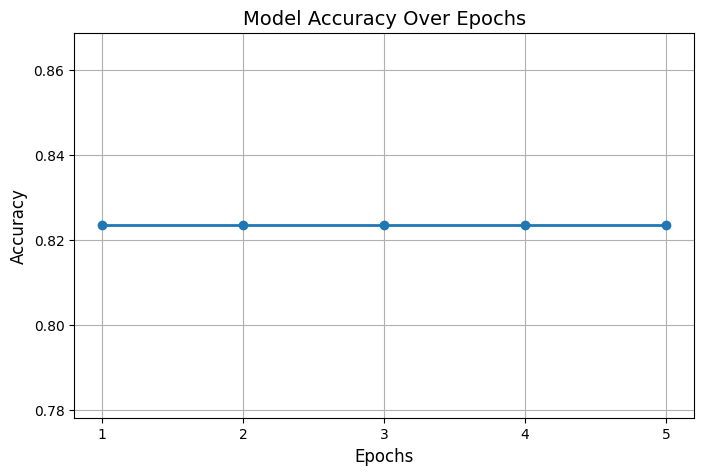

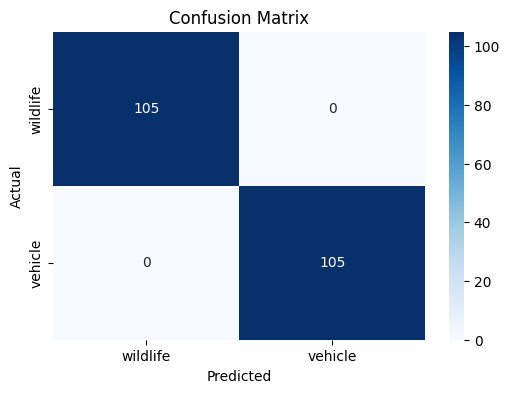

Classification Report:
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         0
     vehicle       1.00      0.84      0.91       125
    wildlife       1.00      0.81      0.89       130

    accuracy                           0.82       255
   macro avg       0.67      0.55      0.60       255
weighted avg       1.00      0.82      0.90       255



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
dataset_path = "/content/drive/MyDrive/archive-2/mobilenet-validate"
categories = ["wildlife", "vehicle"]

# Load the pre-trained model
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/new_labels.txt"

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
print("✅ Model loaded successfully!")

# Load label mappings
def load_labels_from_txt(path):
    label_map = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(":")
            if len(parts) == 2:
                index, name = parts
                label_map[int(index.strip())] = name.strip()
    return label_map

category_index = load_labels_from_txt(PATH_TO_LABELS)
print("✅ Labels Loaded Correctly:", category_index)

# Function to run inference
def run_inference(image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    best_score_idx = np.argmax(scores[0])
    best_class_id = int(classes[0][best_score_idx])
    best_score = scores[0][best_score_idx]

    label = category_index.get(best_class_id, "Unknown")
    return label, best_score

# Evaluate accuracy
true_labels = []
predicted_labels = []
epochs = 5
accuracies = []
misclassified = []

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for epoch in range(epochs):
            correct = 0
            total = 0
            for category in categories:
                folder_path = os.path.join(dataset_path, category)
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)
                    predicted_label, confidence = run_inference(
                        image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections
                    )

                    true_labels.append(category)
                    predicted_labels.append(predicted_label)
                    total += 1

                    if predicted_label == category:
                        correct += 1
                    else:
                        misclassified.append((image_name, category, predicted_label, confidence))

            accuracy = correct / total if total > 0 else 0
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f} ({correct}/{total})")

# Print misclassified images
print("\n🚨 Misclassified Images:")
for img_name, true_label, pred_label, conf in misclassified:
    print(f"❌ {img_name} | True: {true_label} | Predicted: {pred_label} (Confidence: {conf:.2f})")

# Plot accuracy over epochs
if len(accuracies) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Accuracy Over Epochs', fontsize=14)
    plt.xticks(range(1, len(accuracies)+1))
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No accuracy data recorded. Check dataset and model outputs.")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=categories)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
unique_labels = sorted(set(true_labels + predicted_labels))  # Ensure all detected labels are included
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
✅ Labels Loaded Correctly: {0: 'unlabeled', 1: 'none', 2: 'vehicle', 3: 'vehicle', 4: 'vehicle', 5: 'vehicle', 6: 'vehicle', 7: 'vehicle', 8: 'vehicle', 9: 'vehicle', 10: 'none', 11: 'none', 12: 'none', 13: 'none', 14: 'none', 15: 'none', 16: 'wildlife', 17: 'wildlife', 18: 'wildlife', 19: 'wildlife', 20: 'wildlife', 21: 'wildlife', 22: 'wildlife', 23: 'wildlife', 24: 'wildlife', 25: 'wildlife', 26: 'none', 27: 'none', 28: 'none', 29: 'none', 30: 'none', 31: 'none', 32: 'none', 33: 'none', 34: 'none', 35: 'none', 36: 'none', 37: 'none', 38: 'none', 39: 'none', 40: 'none', 41: 'none', 42: 'none', 43: 'none', 44: 'none', 45: 'none', 46: 'none', 47: 'none', 48: 'none', 49: 'none', 50: 'none', 51: 'none', 52: 'none', 53: 'none', 54: 'none', 55: 'none', 56: 'none', 57: 'none', 58: 'none', 59: 'none', 60: 'none', 61: 'none', 62: 'none',

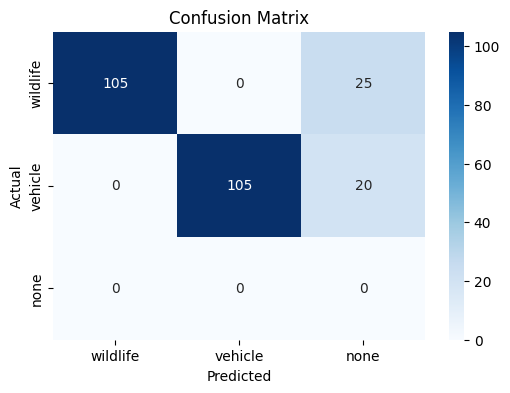

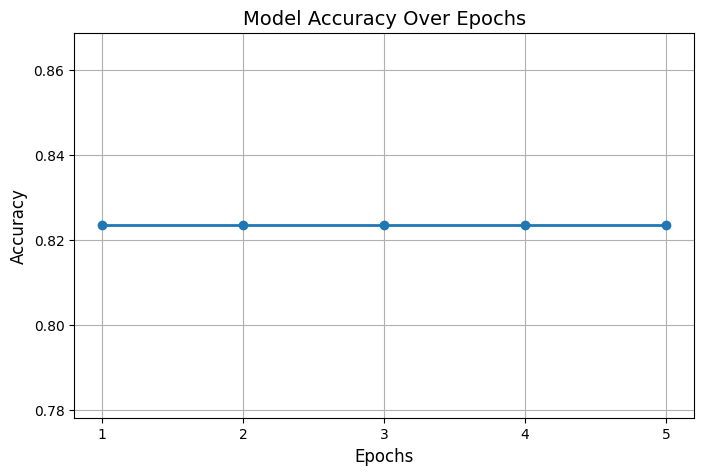

Classification Report:
              precision    recall  f1-score   support

        none       0.00      0.00      0.00         0
     vehicle       1.00      0.84      0.91       125
    wildlife       1.00      0.81      0.89       130

    accuracy                           0.82       255
   macro avg       0.67      0.55      0.60       255
weighted avg       1.00      0.82      0.90       255



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#working
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
dataset_path = "/content/drive/MyDrive/archive-2/mobilenet-validate"
categories = ["wildlife", "vehicle"]

# Load the pre-trained model
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/new_labels.txt"

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
print("✅ Model loaded successfully!")

# Load label mappings
def load_labels_from_txt(path):
    label_map = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(":")
            if len(parts) == 2:
                index, name = parts
                label_map[int(index.strip())] = name.strip()
    return label_map

category_index = load_labels_from_txt(PATH_TO_LABELS)
print("✅ Labels Loaded Correctly:", category_index)

# Function to run inference
def run_inference(image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    best_score_idx = np.argmax(scores[0])
    best_class_id = int(classes[0][best_score_idx])
    best_score = scores[0][best_score_idx]

    label = category_index.get(best_class_id, "none")  # Ensure unknowns are "none"
    return label, best_score

# Evaluate accuracy
true_labels = []
predicted_labels = []
epochs = 5
accuracies = []
misclassified = []

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for epoch in range(epochs):
            correct = 0
            total = 0
            for category in categories:
                folder_path = os.path.join(dataset_path, category)
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)
                    predicted_label, confidence = run_inference(
                        image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections
                    )

                    true_labels.append(category)
                    predicted_labels.append(predicted_label)
                    total += 1

                    if predicted_label == category:
                        correct += 1
                    else:
                        misclassified.append((image_name, category, predicted_label, confidence))

            accuracy = correct / total if total > 0 else 0
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f} ({correct}/{total})")

# Print misclassified images
print("\n🚨 Misclassified Images:")
for img_name, true_label, pred_label, conf in misclassified:
    print(f"❌ {img_name} | True: {true_label} | Predicted: {pred_label} (Confidence: {conf:.2f})")

# Ensure "none" class is included in the confusion matrix
all_labels = categories + ["none"]
cm = confusion_matrix(true_labels, predicted_labels, labels=all_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot accuracy over epochs
if len(accuracies) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Accuracy Over Epochs', fontsize=14)
    plt.xticks(range(1, len(accuracies)+1))
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No accuracy data recorded. Check dataset and model outputs.")

# Display classification report
unique_labels = sorted(set(true_labels + predicted_labels))  # Ensure all detected labels are included
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))

In [ ]:

# Step 1: Mount Google Drive to Access Files
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Download and Extract the Model
# !wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
# !tar -xvzf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

# Step 3: Install Dependencies
# import tensorflow as tf
# import numpy as np
# import cv2
# import os
# from google.colab.patches import cv2_imshow

# Step 4: Load the Model
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
# PATH_TO_LABELS = "ssd_mobilenet_v2_coco_2018_03_29/labels.txt"  # Use labels.txt from repo
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/labels.txt"  # Use labels.txt from repo

# Load the frozen model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

print("✅ Model loaded successfully!")


import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Step 1: Function to Gather Images from Subdirectories
def get_image_paths(directory):
    """Collects all image paths and their corresponding class labels."""
    image_paths = []
    class_labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):  # Skip non-folder files
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if image_path.endswith(('.jpg', '.png', '.jpeg')):  # Filter images
                image_paths.append(image_path)
                class_labels.append(class_name.lower())  # Store folder name as the label

    return image_paths, class_labels

# Step 2: Optimized Function to Compute Accuracy
def compute_accuracy(image_paths, class_labels):
    """Runs inference and calculates accuracy efficiently using a single session."""
    correct_predictions = 0
    total_images = len(image_paths)

    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
            # Get model input/output tensors
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

            for image_path, true_label in zip(image_paths, class_labels):
                image = cv2.imread(image_path)
                print(f"Processing image1: {image_path}")
                if image is None:
                    continue  # Skip unreadable images
                print(f"Processing image2: {image_path}")
                # Resize image to expected input shape (300x300)
                image_resized = cv2.resize(image, (300, 300))
                image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
                image_expanded = np.expand_dims(image_rgb, axis=0)

                # Run inference on the image
                (scores, classes) = sess.run(
                    [detection_scores, detection_classes],
                    feed_dict={image_tensor: image_expanded})

                # Get top prediction
                predicted_class_id = int(classes[0][0])
                predicted_label = category_index.get(predicted_class_id, "Unknown").lower()

                # Compare prediction with actual class (folder name)
                if predicted_label == true_label:
                    correct_predictions += 1

    accuracy = correct_predictions / total_images if total_images > 0 else 0
    return accuracy

# Step 3: Run Accuracy Computation
train_path = "/content/drive/MyDrive/archive-2/train_new/"
validation_path = "/content/drive/MyDrive/archive-2/validation_new/"

train_accuracies = []
validation_accuracies = []
epochs = 3  # Change as needed

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}...")

    train_image_paths, train_labels = get_image_paths(train_path)
    validation_image_paths, validation_labels = get_image_paths(validation_path)

    train_accuracy = compute_accuracy(train_image_paths, train_labels)
    validation_accuracy = compute_accuracy(validation_image_paths, validation_labels)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")

# Step 4: Plot the Accuracy Graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_accuracies, label="Training Accuracy", color='blue')
plt.plot(range(1, epochs+1), validation_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
Epoch 1/3...
Processing image1: /content/drive/MyDrive/archive-2/train_new/cat/cat-image.png
Processing image2: /content/drive/MyDrive/archive-2/train_new/cat/cat-image.png
Processing image1: /content/drive/MyDrive/archive-2/train_new/dog/golden.jpg
Processing image2: /content/drive/MyDrive/archive-2/train_new/dog/golden.jpg
Processing image1: /content/drive/MyDrive/archive-2/train_new/human/2.jpg
Processing image2: /content/drive/MyDrive/archive-2/train_new/human/2.jpg
Processing image1: /content/drive/MyDrive/archive-2/train_new/human/5.jpg
Processing image2: /content/drive/MyDrive/archive-2/train_new/human/5.jpg
Processing image1: /content/drive/MyDrive/archive-2/train_new/human/8.jpg
Processing image2: /content/drive/MyDrive/archive-2/train_new/human/8.jpg
Processing image1: /content/drive/MyDrive/archive-2/train_new/human/9.j

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import UnidentifiedImageError  # Handle corrupt image errors

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define Paths to Your Dataset
train_path = "/content/drive/MyDrive/archive-2/train"
validation_path = "/content/drive/MyDrive/archive-2/validation"

# Step 3: Function to Clean the Dataset (Remove Corrupt & Non-Image Files)
def clean_dataset(directory):
    """Deletes non-image files and corrupt images from dataset."""
    valid_extensions = (".jpg", ".jpeg", ".png")  # Allowed image formats

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):  # Skip non-folder files
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Remove non-image files
            if not image_path.lower().endswith(valid_extensions):
                print(f"❌ Removing non-image file: {image_path}")
                os.remove(image_path)
                continue

            # Check for corrupt images
            try:
                img = tf.keras.preprocessing.image.load_img(image_path)
            except (UnidentifiedImageError, OSError):
                print(f"❌ Corrupt image detected, removing: {image_path}")
                os.remove(image_path)

# Step 4: Run Cleanup on Both Train & Validation Datasets
clean_dataset(train_path)
clean_dataset(validation_path)

# Step 5: Dynamically Get the Correct Number of Classes
def count_classes(directory):
    """Returns the number of valid class folders."""
    return len([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

num_classes_train = count_classes(train_path)
num_classes_val = count_classes(validation_path)

if num_classes_train != num_classes_val:
    raise ValueError(f"❌ ERROR: Training has {num_classes_train} classes, but Validation has {num_classes_val}.")

num_classes = num_classes_train
print(f"✅ Using {num_classes} classes.")

# Step 6: Load Pre-Trained MobileNetV2 for Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Step 7: Add a New Classification Head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Dynamically adjust class count

model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Step 8: Freeze Pre-Trained Layers (Optional for Faster Training)
for layer in base_model.layers:
    layer.trainable = False  # Keep pre-trained weights

# Step 9: Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 10: Load Data Using Keras ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Step 11: Train the Model
epochs = 15  # Increase for better accuracy
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

# Step 12: Plot the Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Mounted at /content/drive
❌ Corrupt image detected, removing: /content/drive/MyDrive/archive-2/train/cougar/7.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/archive-2/train/cougar/7.jpg'

Mounted at /content/drive
✅ Using 15 classes.
Found 1478 images belonging to 15 classes.
Found 838 images belonging to 15 classes.
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.0915 - loss: 2.9976 - val_accuracy: 0.3747 - val_loss: 2.1889
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.2966 - loss: 2.1855 - val_accuracy: 0.6050 - val_loss: 1.7286
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.4518 - loss: 1.8274 - val_accuracy: 0.7112 - val_loss: 1.3595
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5543 - loss: 1.5197 - val_accuracy: 0.7733 - val_loss: 1.0913
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6149 - loss: 1.3012 - val_accuracy: 0.8115 - val_loss: 0.9073
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.6491 - loss: 1.1732 - val_accuracy: 0.8305 - val_loss: 0.7776
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7121 - loss: 0.9954 - val_accuracy: 0.8377

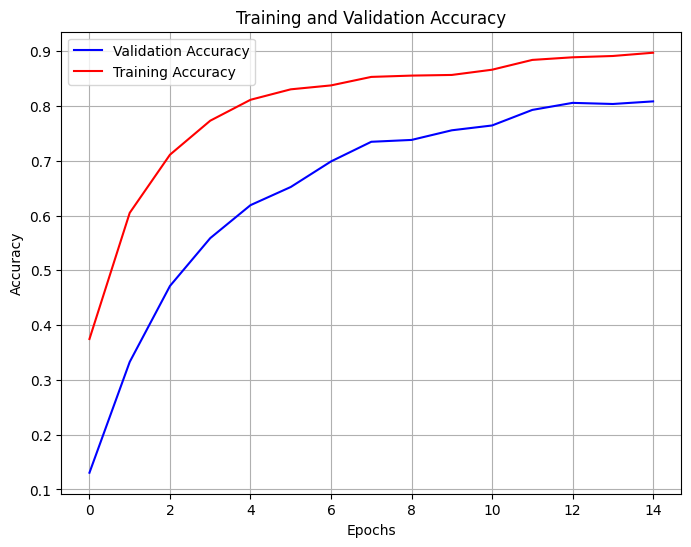

In [4]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError  # Handle corrupt image errors

# Step 1: Mount Google Drive (Force Remount in case of issues)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 2: Define Paths to Your Dataset
train_path = "/content/drive/MyDrive/archive-2/train"
validation_path = "/content/drive/MyDrive/archive-2/validation"

# Step 3: Function to Clean the Dataset (Remove Corrupt & Non-Image Files)
# def clean_dataset(directory):
#     """Deletes non-image files and corrupt images from dataset."""
#     valid_extensions = (".jpg", ".jpeg", ".png")  # Allowed image formats

#     for class_name in os.listdir(directory):
#         class_path = os.path.join(directory, class_name)
#         if not os.path.isdir(class_path):  # Skip non-folder files
#             continue

#         for image_name in os.listdir(class_path):
#             image_path = os.path.join(class_path, image_name)

#             # Remove non-image files
#             if not image_path.lower().endswith(valid_extensions):
#                 print(f"❌ Removing non-image file: {image_path}")
#                 if os.path.exists(image_path):  # Avoid FileNotFoundError
#                     os.remove(image_path)
#                 continue

#             # Check for corrupt images
#             try:
#                 with Image.open(image_path) as img:
#                     img.verify()  # Verify if it's a valid image
#             except (UnidentifiedImageError, OSError):
#                 print(f"❌ Corrupt image detected, removing: {image_path}")
#                 if os.path.exists(image_path):  # Avoid FileNotFoundError
#                     os.remove(image_path)

# Step 4: Run Cleanup on Both Train & Validation Datasets
# clean_dataset(train_path)
# clean_dataset(validation_path)

# Step 5: Dynamically Get the Correct Number of Classes
def count_classes(directory):
    """Returns the number of valid class folders."""
    return len([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

num_classes_train = count_classes(train_path)
num_classes_val = count_classes(validation_path)

if num_classes_train != num_classes_val:
    raise ValueError(f"❌ ERROR: Training has {num_classes_train} classes, but Validation has {num_classes_val}.")

num_classes = num_classes_train
print(f"✅ Using {num_classes} classes.")

# Step 6: Load Pre-Trained MobileNetV2 for Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Step 7: Add a New Classification Head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Dynamically adjust class count

model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Step 8: Freeze Pre-Trained Layers (Optional for Faster Training)
for layer in base_model.layers:
    layer.trainable = False  # Keep pre-trained weights

# Step 9: Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 10: Load Data Using Keras ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Step 11: Train the Model
epochs = 15  # Increase for better accuracy
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

# Step 12: Plot the Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Validation Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Training Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import os
import tarfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive
from PIL import UnidentifiedImageError  # Handle corrupt image errors

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define Paths to Your Dataset
train_path = "/content/drive/MyDrive/archive-2/train"
validation_path = "/content/drive/MyDrive/archive-2/validation"

# Step 3: Download and Extract Pre-Trained SSD MobileNetV2 COCO 2018 Model
model_url = "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz"
model_tar = "ssd_mobilenet_v2_coco.tar.gz"

# Download the model
if not os.path.exists(model_tar):
    !wget {model_url} -O {model_tar}

# Extract the model
with tarfile.open(model_tar, "r:gz") as tar:
    tar.extractall()

model_dir = "ssd_mobilenet_v2_coco_2018_03_29/saved_model"

# Step 4: Load Pre-Trained SSD MobileNetV2 Model
detect_fn = tf.saved_model.load(model_dir)
print("✅ Pre-trained SSD MobileNetV2 model loaded successfully!")

# Step 5: Function to Clean the Dataset (Remove Corrupt & Non-Image Files)
def clean_dataset(directory):
    """Deletes non-image files and corrupt images from dataset."""
    valid_extensions = (".jpg", ".jpeg", ".png")

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Remove non-image files
            if not image_path.lower().endswith(valid_extensions):
                print(f"❌ Removing non-image file: {image_path}")
                os.remove(image_path)
                continue

            # Check for corrupt images
            try:
                img = tf.keras.preprocessing.image.load_img(image_path)
            except (UnidentifiedImageError, OSError):
                print(f"❌ Corrupt image detected, removing: {image_path}")
                os.remove(image_path)

# Clean the dataset
clean_dataset(train_path)
clean_dataset(validation_path)

# Step 6: Load Dataset Efficiently
batch_size = 32
img_size = (300, 300)  # SSD MobileNetV2 requires 300x300 input

train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    validation_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Step 7: Modify SSD MobileNetV2 for Fine-Tuning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights=None  # Use COCO pre-trained weights
)

# Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Step 8: Add a Custom Classification Head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # Prevent overfitting
output_layer = layers.Dense(len(train_dataset.class_names), activation="softmax")(x)

# Create new model
custom_model = Model(inputs=base_model.input, outputs=output_layer)

# Step 9: Compile the Model with Lower Learning Rate
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Step 10: Train the Model
epochs = 10  # Adjust as needed
history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Step 11: Plot Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Save the Fine-Tuned Model
custom_model.save("ssd_mobilenetv2_finetuned.h5")
print("✅ Fine-tuned model saved successfully!")

# Step 13: Download Fine-Tuned Model
from google.colab import files
files.download("ssd_mobilenetv2_finetuned.h5")


Mounted at /content/drive
--2025-02-23 20:36:24--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.194.207, 172.217.214.207, 142.250.152.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   181MB/s    in 1.0s    

2025-02-23 20:36:25 (181 MB/s) - ‘ssd_mobilenet_v2_coco.tar.gz’ saved [187925923/187925923]

✅ Pre-trained SSD MobileNetV2 model loaded successfully!
Found 1478 files belonging to 15 classes.
Found 838 files belonging to 15 classes.
Epoch 1/10
41/47 ━━━━━━━━━━━━━━━━━━━━ 1:22 14s/step - accuracy: 0.0710 - loss: 2.9576

In [ ]:
import tensorflow as tf
import numpy as np
import os
import tarfile
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import UnidentifiedImageError  # Handle corrupt image errors

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define Paths to Your Dataset
train_path = "/content/drive/MyDrive/archive-2/train"
validation_path = "/content/drive/MyDrive/archive-2/validation"

# Step 3: Download & Extract the Pre-Trained SSD MobileNetV2 COCO 2018 Model
model_url = "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz"
model_tar = "ssd_mobilenet_v2_coco.tar.gz"

if not os.path.exists("ssd_mobilenet_v2_coco_2018_03_29"):
    if not os.path.exists(model_tar):
        !wget {model_url} -O {model_tar}
    with tarfile.open(model_tar, "r:gz") as tar:
        tar.extractall()

model_dir = "ssd_mobilenet_v2_coco_2018_03_29/saved_model"

# Step 4: Load the Pre-Trained Model (TensorFlow Object Detection API)
detect_fn = tf.saved_model.load(model_dir)
print("✅ COCO Pre-Trained SSD MobileNetV2 Loaded!")

# Step 5: Extract the Backbone Feature Extractor from SSD MobileNetV2
# Instead of using `detect_fn` directly, extract the MobileNetV2 backbone
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights=None  # No need to load ImageNet weights
)

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Step 6: Add a Custom Classification Head
from tensorflow.keras import layers, Model

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # Prevent overfitting
output_layer = layers.Dense(len(os.listdir(train_path)), activation="softmax")(x)

# Create a new fine-tuned model
custom_model = Model(inputs=base_model.input, outputs=output_layer)

# Step 7: Compile the Model with Lower Learning Rate
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Low LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Step 8: Load Dataset Efficiently
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_size = (300, 300)  # SSD MobileNetV2 requires 300x300 input

train_dataset = image_dataset_from_directory(
    train_path, image_size=img_size, batch_size=batch_size, label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    validation_path, image_size=img_size, batch_size=batch_size, label_mode='categorical'
)

# Step 9: Train the Model
epochs = 10  # Adjust based on performance
history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Step 10: Plot the Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Save the Fine-Tuned Model
custom_model.save("ssd_mobilenetv2_finetuned.keras")
print("✅ Fine-Tuned Model Saved Successfully!")

# Step 12: Download Fine-Tuned Model
from google.colab import files
files.download("ssd_mobilenetv2_finetuned.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ COCO Pre-Trained SSD MobileNetV2 Loaded!
Found 1478 files belonging to 15 classes.
Found 838 files belonging to 15 classes.
Epoch 1/10
 5/47 ━━━━━━━━━━━━━━━━━━━━ 10:49 15s/step - accuracy: 0.0407 - loss: 3.0123